# Research at CallMeMaybe : identifying the least effective operators

CallMeMaybe is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.
* Carry out exploratory data analysis
* Identify ineffective operators
* Test statistical hypothesis

Our customer is Product Manager, Product Development Department. In the future, on the basis of the present analysis, an algorithm will be developed for embedding into the service as a separate functionality.

## Table Of Content:
1. [Downloading the data](#start)
    - 1.1. [Openning the data](#data)
    - 1.2. [Conclusion](#start-conc)
2. [Carrying out exploratory data analysis (EDA)](#analysis)
    - 2.1 [Checking the data](#analysis-check)
    - 2.2 [EDA](#eda)
    - 2.3 [Conclusion](#analysis-conc)
3. [Testing the hypothesis](#checking)
    - 3.1 [Conclusion](#checking-conc)
4. [Creating clients’ clusters and coming up with conclusions](#clusters)
    - 4.1 [Conclusion](#results-conc)
5. [General conclusion](#conclusion)

# Presentation 
## Link
https://drive.google.com/file/d/1_9hDTR8mm3JQO_YkVWpUADJLGPtaj3mK/view?usp=sharing

## Step 1. Downloading the data <a class="anchor" id="start"></a>

The datasets contain data on the use of the virtual telephony service CallMeMaybe. Its clients are organizations that need to distribute large numbers of incoming calls among various operators or make outgoing calls through their operators. Operators can also make internal calls to communicate with one another. These calls go through CallMeMaybe's network.


In [1]:
import pandas as pd

from matplotlib.gridspec import GridSpec
from datetime import datetime
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 
import matplotlib.ticker as ticker
from collections import Counter 
import scipy.stats as stats
from scipy import stats as st
from pandas.core.common import SettingWithCopyWarning
import warnings


In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.1 Openning the data<a class="anchor" id="data"></a>



In [3]:
#Let’s read the data from the csv and check what we have there.
#table from the csv file will be saved as df1:

df1 = pd.read_csv('/datasets/telecom_dataset_us.csv', sep=',')
df1.info()
display(df1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
#Let’s read the data from the csv and check what we have there.
#table from the csv file will be saved as df2:

df2 = pd.read_csv('/datasets/telecom_clients_us.csv', sep=',')
df2.info()
display(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


### 1.2 Conclusion <a class="anchor" id="start-conc"></a>

In the present research we are working with a 2 datasets that contain data on the use of the virtual telephony service CallMeMaybe.

Datasets were saved in the following tables:



**df1** - 1st dataset telecom_dataset_us.csv - its total length is 53901 rows, every row represents one client's activity log and its characteristics in columns:
* user_id — client account ID
* date — date the statistics were retrieved
* direction — call direction (out for outgoing, in for incoming)
* internal — whether the call was internal (between a client's operators)
* operator_id — operator identifier
* is_missed_call — whether the call was missed
* calls_count — number of calls user did in particular date to particular operator_id with particular direction and so on
* call_duration — call duration (excluding waiting time) - in seconds
* total_call_duration — call duration (including waiting time)

**df2** -  2nd dataset telecom_clients_us.csv - its total length is 732 rows, every row represents one client's account and its characteristics in columns:
* user_id
* tariff_plan — client's current plan
* date_start — client's registration date

## Step 2. Carrying out exploratory data analysis (EDA) <a class="anchor" id="analysis"></a>

* Looking at the dataset: 
    * studying the data they contain 
    * making sure the data types are correct 
    * checking missing values
* Ploting bar histograms and feature distributions
* Building a correlation matrix and display it
* Identifying the top 10 operators in terms of missed calls 
* Identifying the top 10 operators in terms of long wait
* Making graphs: clients and number of calls, top 10 operators by missed calls  and long wait
* Drawing conclusions 


### 2.1 Checking the data <a class="anchor" id="analysis-check"></a>

Checking for **duplicates**

In [5]:
df2[df2.duplicated()]
#no duplicates in df2

,user_id,tariff_plan,date_start


In [6]:
df1[df1.duplicated()]
#there are almost 5k duplicated values in df1

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89


In [7]:
#let's drop duplicates
df1 = df1.drop_duplicates().reset_index(drop=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
user_id                49002 non-null int64
date                   49002 non-null object
direction              49002 non-null object
internal               48892 non-null object
operator_id            41546 non-null float64
is_missed_call         49002 non-null bool
calls_count            49002 non-null int64
call_duration          49002 non-null int64
total_call_duration    49002 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


 Let's check **missing values**

In [8]:
#checking missing values in df2
df2[df2.isnull().any(axis=1)] 
#no missing values in df2

,user_id,tariff_plan,date_start


In [9]:
#checking missing values in df1
df1[df1.isnull().any(axis=1)] 

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
16,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
26,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
48978,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
48982,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
48990,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
48994,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


In [10]:
#checking missing values - operator_id
df1.operator_id.isnull().sum()

7456

In [11]:
#since there are many (7511 entries where 7456 are for operator_id) - 
#let's create a separate table and study what we have inside
df=df1.query('operator_id.isnull()')

#let's merge it with user's data column
df=df.merge(df2, on='user_id', how='left')
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,B,2019-08-01
2,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,B,2019-08-01
3,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24,B,2019-08-01
4,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34,B,2019-08-01


In [12]:
#checking unique users
df.user_id.nunique()

305

In [13]:
#checking plan
x=df.groupby(['tariff_plan']).agg({'user_id':'nunique'}).reset_index()
x

,tariff_plan,user_id
0,A,33
1,B,112
2,C,160


In [14]:
#checking wheather those calls were missed
df.groupby(['is_missed_call']).size()

is_missed_call
False     113
True     7343
dtype: int64

In [15]:
#checking wheather those calls were internal
df.groupby(['internal']).size()

internal
False    7078
True      323
dtype: int64

In [16]:
#checking wheather those calls were incoming
df.groupby(['direction']).size()

direction
in     7270
out     186
dtype: int64

So we have 15% of missing values for operator_id out of the whole dataset. Since our goal is to identify the inefficient operators (based on their operator_id), this column is mandatory for our research. Thus, we have to drop all these 7456 logs that have Null in operator_id. In general, we can say that mostly data contains the calls tha were missed, incoming, external, for 305 unique users from the following tariff: C 52%, B 37%, A 10%.

In [17]:
#checking missing values - internal
df1.internal.isnull().sum()
#110 missing values regarding internal calls (55 not related to missing operator_id)

110

In [18]:
df1.dropna(subset=["operator_id"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 1 to 49000
Data columns (total 9 columns):
user_id                41546 non-null int64
date                   41546 non-null object
direction              41546 non-null object
internal               41491 non-null object
operator_id            41546 non-null float64
is_missed_call         41546 non-null bool
calls_count            41546 non-null int64
call_duration          41546 non-null int64
total_call_duration    41546 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 2.9+ MB


Let's drop users with null in operator_id.

In [19]:
df1.dropna(inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 49000
Data columns (total 9 columns):
user_id                41491 non-null int64
date                   41491 non-null object
direction              41491 non-null object
internal               41491 non-null object
operator_id            41491 non-null float64
is_missed_call         41491 non-null bool
calls_count            41491 non-null int64
call_duration          41491 non-null int64
total_call_duration    41491 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 2.9+ MB


Changing **data types**

In [20]:
df1['operator_id'] = df1['operator_id'].astype(int)
df1.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5


In [21]:
#let's save operator_id and user_id as string
df1['operator_id'] = df1['operator_id'].astype(int)
df1['operator_id'] = df1['operator_id'].apply(str)
df1['user_id'] = df1['user_id'].apply(str)
df2['user_id'] = df2['user_id'].apply(str)

In [22]:
#let's make sure all date columns are saved as date data type instead of string

df1['date'] = df1['date'].astype('datetime64[D]')

df2['date_start'] = pd.to_datetime(df2['date_start']).dt.normalize()

Let's merge our tables df1 and df2

In [23]:
df=df1.merge(df2, on='user_id', how='left')
df.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01


### 2.2 EDA <a class="anchor" id="eda"></a>

Checking **research time frame**

In [24]:
#period of time does the data cover (max and min event date)
print('Min date:',df.date.min())
print('Max date:',df.date.max())

Min date: 2019-08-01 00:00:00
Max date: 2019-11-27 00:00:00


In [25]:
#period of time of registration (max and min date)
print('Min date:',df.date_start.min())
print('Max date:',df.date_start.max())

Min date: 2019-08-01 00:00:00
Max date: 2019-10-31 00:00:00


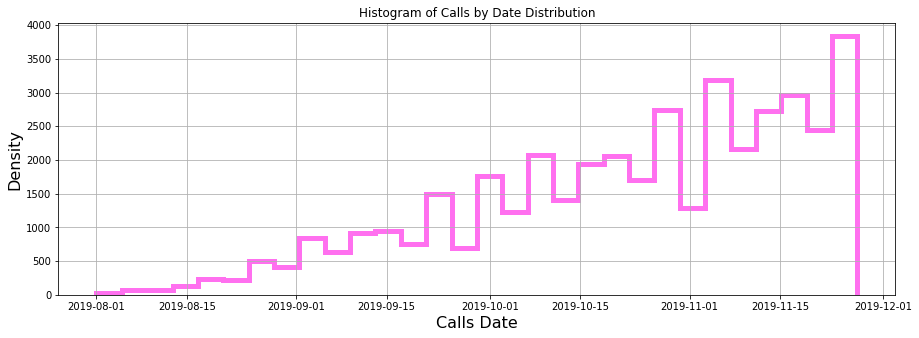

In [26]:
#histogram by date and time
plt.xlabel("Calls Date", fontsize=16)  
plt.ylabel("Density", fontsize=16)
plt.title("Histogram of Calls by Date Distribution")
df.date.hist(
    bins = 30, histtype='step', 
    alpha=0.7, grid=True, figsize = (15,5),
    linewidth=5, color='#ff33e9')
plt.show()

Period of time does the data covers from 2019-08-01 to 2019-11-27 with continous growth of entries towards the end of the period.

Number of operators

In [27]:
df1.operator_id.nunique()

1092

Checking **missed call** duration

In [28]:
#let's check call duration for those calls that were missed
missed=df1.query('is_missed_call == True')
missed.describe()

,calls_count,call_duration,total_call_duration
count,14109.000000,14109.000000,14109.000000
mean,19.301014,1.678078,447.141116
std,75.546375,22.017520,1544.334154
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,19.000000
50%,4.000000,0.000000,83.000000
75%,14.000000,0.000000,329.000000
max,4817.000000,741.000000,45312.000000


In [29]:
#let's find calls with duration more than 0 for those missed calls (call duration for all users for missed calls)
missed.query('call_duration > 0').call_duration.sum()
missed_bug=missed.query('call_duration > 0')

In [30]:
#let's check call_duration per user 
sec_to_substract=missed_bug.groupby('user_id').agg({'call_duration':'sum'}).reset_index()
sec_to_substract

,user_id,call_duration
0,166405,167
1,166407,133
2,166482,1
3,166485,110
4,166503,217
...,...,...
56,168264,1
57,168271,3
58,168307,57
59,168336,206


In [31]:
#as this looks like a defect, let's replace call duration for missed calls with 0 
df1.loc[df1['is_missed_call'] == True, 'call_duration'] = 0
#let's check if anything left behind
df1.query('is_missed_call == True and call_duration > 0')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


Ploting **histograms and feature distributions**


In [32]:
#let's create a features table
features=df[['direction','internal','operator_id','is_missed_call',
             'calls_count','call_duration','total_call_duration','tariff_plan']]

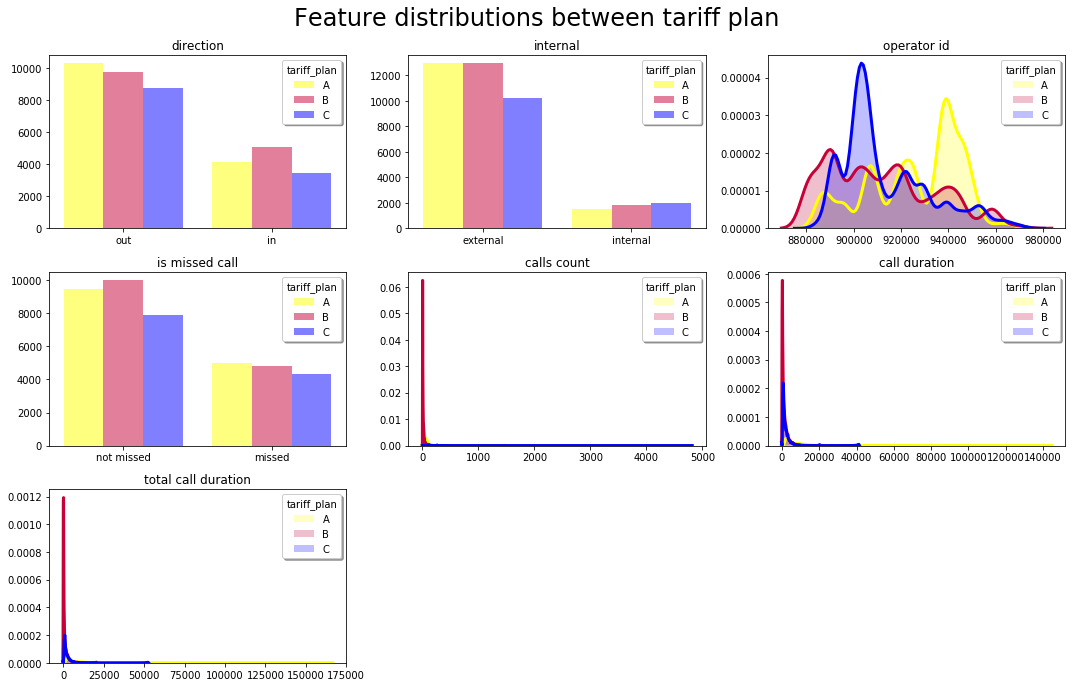

In [88]:
#let's define plot distribution of features 
colors = ['yellow','#C70039','blue']

def plot_dist(df, feature):
    plt.figure(figsize=(15,15))
    the_grid = GridSpec(5, 3)
    # place in grid for plot
    for i, column in enumerate(df.drop(feature, axis = 1).columns):
        plt.subplot(the_grid[i//3, i%3], title=column.replace('_',' '))
        values = len(df[column].unique())
        features = sorted(df[feature].unique())
    # continuous vs discrete
        if values > 12:    
            for i,x in enumerate(features):
                sns.distplot(df[df[feature] == x][column], hist = False, 
                             kde_kws = {'shade': True, 'linewidth': 3}, color=colors[i])
        else:
            sns.countplot(column, hue=feature, data=df, palette=colors, alpha=.5, saturation=1)
            plt.gca().get_legend().remove()
     # xticks
            if values == 2:
                if column == 'direction':
                    plt.xticks(np.arange(values),('out','in'))
                if column == 'is_missed_call':
                    plt.xticks(np.arange(values),('not missed','missed'))
                if column == 'internal':
                    plt.xticks(np.arange(values),('external','internal'))
                if column == 'long_wait_inc':
                    plt.xticks(np.arange(values),('short wait','long wait'))
     # legend             
        legend = features
        plt.legend(legend, shadow=True, fancybox=True, title=feature, loc='best')
        plt.xlabel('')
        plt.ylabel('')
    plt.tight_layout()
    plt.suptitle('Feature distributions between tariff plan', fontsize=24, y=1.02)
    plt.show()
plot_dist(features,'tariff_plan')

In [34]:
print('Major operator for tariff A: id {} times' .format((df.query('tariff_plan == "A"').operator_id.value_counts().nlargest(1)).to_string(index=True)))
print('Major operator for tariff B: id {} times' .format((df.query('tariff_plan == "B"').operator_id.value_counts().nlargest(1)).to_string(index=True)))
print('Major operator for tariff C: id {} times' .format((df.query('tariff_plan == "C"').operator_id.value_counts().nlargest(1)).to_string(index=True)))

Major operator for tariff A: id 885876    283 times
Major operator for tariff B: id 887276    267 times
Major operator for tariff C: id 901884    323 times


While checking feature values we see that there are much more outgoing calls than incoming calls (leader is tariff A), that most clients call externally (out of their network) with the euqal distribution between tariff A and B vs much smaller part in tariff C (while tariff C is a leader in internal network calls), that the major operator in use for tariff C is 901884. 

In [35]:
print('Average number of calls:', round(df1.calls_count.mean()))
print('Average call duration:', round(df1.call_duration.mean()))
print('Average total call duration:', round(df1.total_call_duration.mean()))

Average number of calls: 17
Average call duration: 1010
Average total call duration: 1323


Let's check **call duration outliers**

In [36]:
filtered_anomaly=df1.query('call_duration <= 2000')
#filtered_anomaly

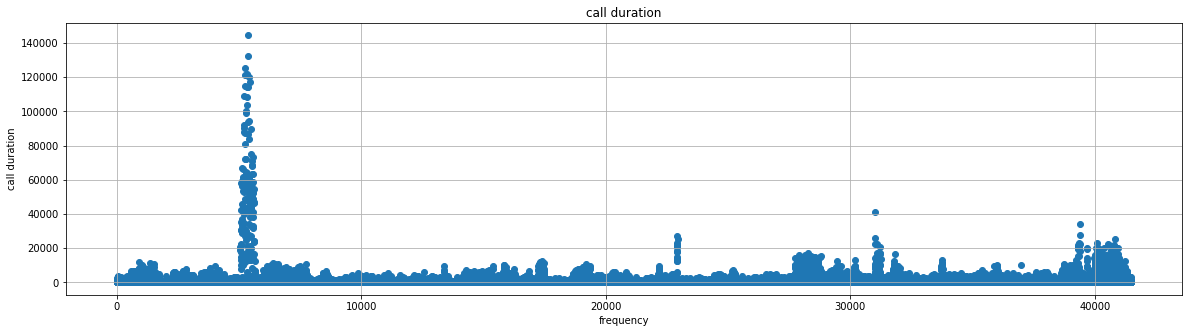

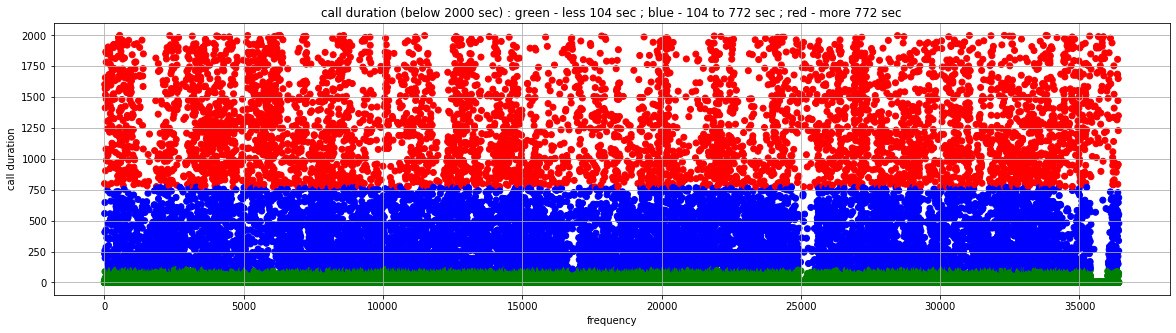

In [37]:
#Let's study data on calls in order to identify outliers 
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0, len(df1['call_duration'])))
plt.scatter(x_values, df1['call_duration']) 
plt.title('call duration')
plt.xlabel("frequency")
plt.ylabel("call duration")
plt.grid()
plt.show()

#let's zoom in and see the call duration below 1000 sec
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0, len(filtered_anomaly['call_duration'])))
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>104 and l<772:
            cols.append('blue')
        elif l>=772:
            cols.append('red')
        else:
            cols.append('green')
    return cols
cols=pltcolor(filtered_anomaly['call_duration'])
plt.scatter(x_values, filtered_anomaly['call_duration'],c=cols)
plt.title('call duration (below 2000 sec) : green - less 104 sec ; blue - 104 to 772 sec ; red - more 772 sec')
plt.xlabel("frequency")
plt.ylabel("call duration")
plt.grid()
plt.show()

In [38]:
df.describe()

,calls_count,call_duration,total_call_duration
count,41491.000000,41491.000000,41491.000000
mean,16.921381,1010.940011,1323.153238
std,59.786187,4066.666485,4788.953155
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,67.000000
50%,4.000000,106.000000,289.000000
75%,14.000000,772.000000,1107.000000
max,4817.000000,144395.000000,166155.000000


In [39]:
#how many percent of calls out of total last longer than 2000 sec
round(df1.query('call_duration > 2000').user_id.count()/len(df1),2)

0.12

Then, while checking features further, we saw that the average number of calls is 17, the average call duration is 1010 and the average total call duration is 1323. So, we decided to dig and dive into the call duration feature. We saw that the median, 50% of users, made 104 sec call duration and 75% of users mad 772 sec call duration. In total 12% of calls were longer than 2000 sec.


Let's check **waiting duration outliers**

In [40]:
#creating column for the wait duration
df['wait_sec'] = df['total_call_duration'] - df['call_duration']
df.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_sec
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5
1,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1


In [41]:
#Let's calculate the 95th and 99th sample percentiles for the waiting period of incoming calls
print(np.percentile(df.query('direction == "in"')['wait_sec'], [95, 99])) 

[376. 928.]


When checking the 95th and 99th sample percentiles for the waiting period, we found that not more than 5% of calls has value of more than 376, and 1% of incoming calls has waiting time of more than 928. Thus, it would be reasonable to set 376 sec per incoming calls as the lower limit and to filter anomalies on that basis.

In [42]:
filtered_anomaly_wait=df.query('wait_sec <= 376 and direction == "in"')
#filtered_anomaly_wait

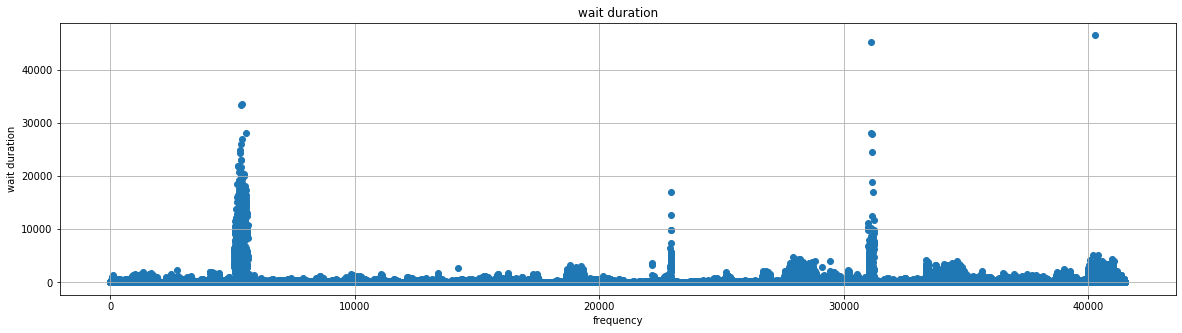

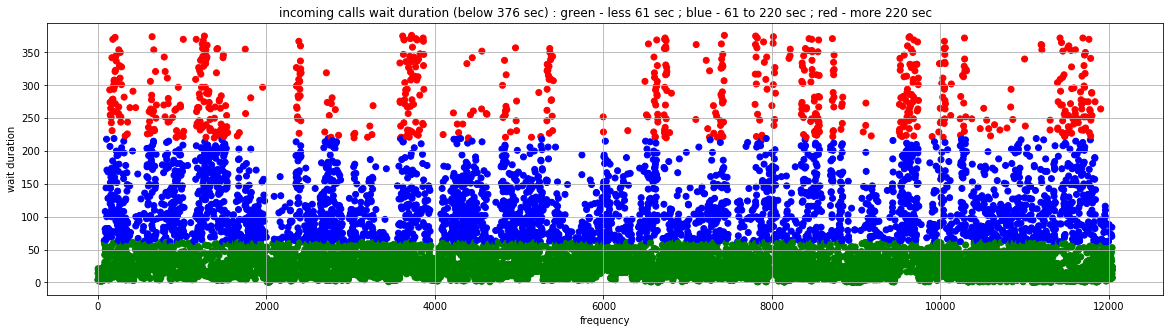

In [43]:
#Let's study data on incoming calls in order to identify outliers 
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0, len(df['wait_sec'])))
plt.scatter(x_values, df['wait_sec']) 
plt.title('wait duration')
plt.xlabel("frequency")
plt.ylabel("wait duration")
plt.grid()
plt.show()

#let's zoom in and see the call duration below 1234 sec
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0, len(filtered_anomaly_wait['wait_sec'])))
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>61 and l<220:
            cols.append('blue')
        elif l>=220:
            cols.append('red')
        else:
            cols.append('green')
    return cols
cols=pltcolor(filtered_anomaly_wait['wait_sec'])
plt.scatter(x_values, filtered_anomaly_wait['wait_sec'],c=cols)
plt.title('incoming calls wait duration (below 376 sec) : green - less 61 sec ; blue - 61 to 220 sec ; red - more 220 sec')
plt.xlabel("frequency")
plt.ylabel("wait duration")
plt.grid()
plt.show()

While checking the waiting time duration (total call duration minus call duration), we saw that the average length of waiting period is 312 sec, the median, 50% of users, were waiting for 61 sec and 75% of users - 220 sec. In total 5% of **incoming calls' waiting time** was longer than 376 sec. Thus, let's set 376 seconds as a limit for the long waiting time for incoming calls.

Building a **correlation matrix**

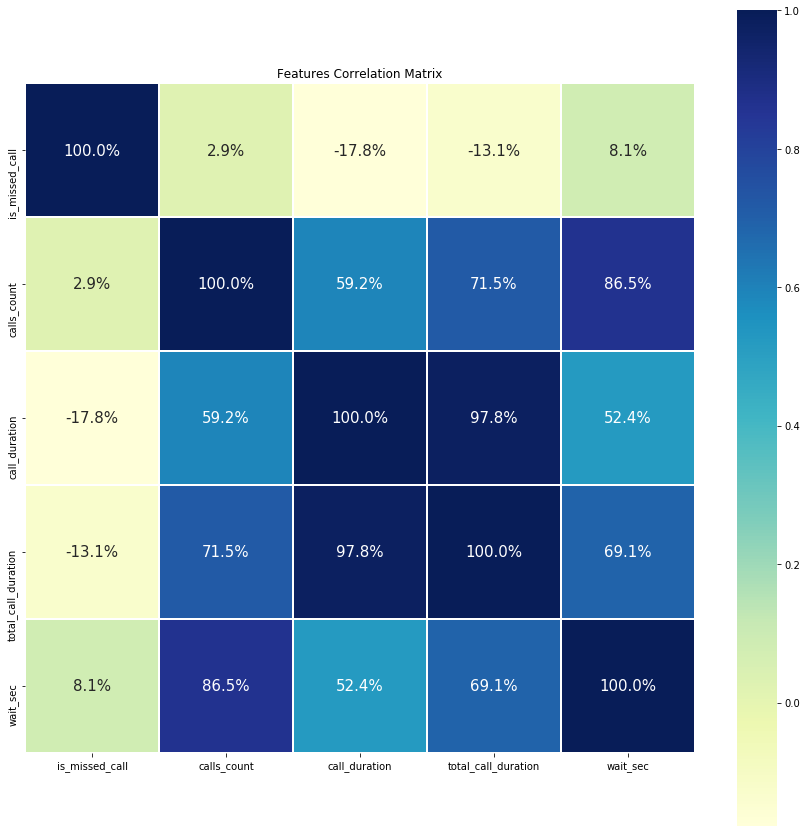

In [44]:
# correlation matrix
corr_m = df.corr() 
plt.figure(figsize=(15,15))
sns.heatmap(corr_m, square = True, annot = True, fmt='.1%',cmap="YlGnBu", annot_kws={"size":15}, linewidths=.5)
plt.title('Features Correlation Matrix')
plt.show()

When we checked correlation matrix we found that there is a strong correlation (98%) between total call duration and call duration,  number of calls and waiting period (87%), number of calls and total call duration (72%) and between total call duration and waiting period (69%). 

Identifying the **top 10 operators in terms of missed calls**


In [45]:
missed_op=df1.query('is_missed_call == True').groupby('operator_id'
                                                     ).agg({'calls_count':'sum'}
                                                          ).sort_values(
    by='calls_count', ascending=False).head(10).reset_index()
missed_op

,operator_id,calls_count
0,885890,23807
1,885876,23330
2,929428,19118
3,925922,9258
4,908640,8164
5,929426,6347
6,945286,3626
7,945302,3184
8,919364,2688
9,879898,2360


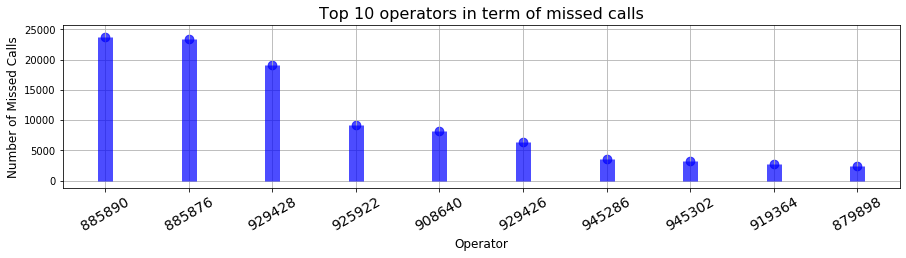

In [46]:
# let's plot chart for top 10 operators in term of missed calls
fig,ax=plt.subplots(figsize=(15,3))
plt.grid()
ax.vlines(x=missed_op.operator_id, ymin=0,
          ymax=missed_op.calls_count, color='blue', alpha=0.7,linewidth=15)
ax.set_title('Top 10 operators in term of missed calls', fontdict={'size':16})
ax.set_ylabel('Number of Missed Calls', fontdict={'size':12})
ax.set_xlabel('Operator', fontdict={'size':12})
ax.set_xticks(missed_op.operator_id)
ax.set_xticklabels(missed_op.operator_id, rotation=30, fontdict={'size':14})

ax.scatter(x=missed_op.operator_id, y=missed_op.calls_count, s=75, color='blue', alpha=0.7)

plt.show()

We can see that top 3 operators with the missed calls: 
- 885890.0 - 23,807 calls
- 885876.0 - 23,330 calls
- 929428.0 - 19,118 calls

Identifying the **top 10 operators in terms of long wait**


As we mentioned earlier, our assumption is that waiting time longer than 1000 seconds (~17 min) is our long wait, and it should be incoming call.

In [47]:
#let's find those operators and sum up calls that have this condition (waiting time longer than 376 sec)
long_wait_op=df.query('wait_sec > 376 and direction == "in"').groupby('operator_id'
                                                     ).agg({'calls_count':'sum'}
                                                          ).sort_values(
    by='calls_count', ascending=False).head(10).reset_index()
long_wait_op

,operator_id,calls_count
0,913938,4314
1,921318,2170
2,913942,1960
3,931458,1873
4,919790,1490
5,919204,1156
6,919794,1135
7,919554,1078
8,919552,963
9,919206,916


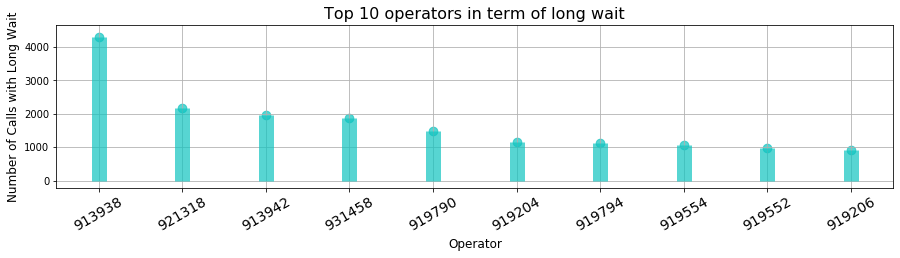

In [48]:
# let's plot chart for top 10 operators in term of long wait
fig,ax=plt.subplots(figsize=(15,3))
plt.grid()
ax.vlines(x=long_wait_op.operator_id, ymin=0,
          ymax=long_wait_op.calls_count, color='#10c4c0', alpha=0.7,linewidth=15)
ax.set_title('Top 10 operators in term of long wait', fontdict={'size':16})
ax.set_ylabel('Number of Calls with Long Wait', fontdict={'size':12})
ax.set_xlabel('Operator', fontdict={'size':12})
ax.set_xticks(long_wait_op.operator_id)
ax.set_xticklabels(long_wait_op.operator_id, rotation=30, fontdict={'size':14})

ax.scatter(x=long_wait_op.operator_id, y=long_wait_op.calls_count, s=75, color='#10c4c0', alpha=0.7)

plt.show()

We can see that top 3 operators in terms of the biggest number of long wait incoming calls are: 
- operator 913938	- 4314 calls
- operator 921318	- 2170 calls
- operator 913942	- 1960 calls

Making graph: **clients and number of calls**

In [49]:
#let's check total number of calls for each client 
x = df.groupby('user_id').agg({'calls_count':'sum'}).reset_index()
x.head(1)

,user_id,calls_count
0,166377,5054


In [50]:
x.describe()

,calls_count
count,290.000000
mean,2420.982759
std,10498.023786
min,1.000000
25%,25.500000
50%,167.500000
75%,1320.750000
max,139671.000000


In [51]:
#how many percent of clients out of total have more than 1320 calls
round(x.query('calls_count > 1320').user_id.nunique()/(x.user_id.nunique()),2)

0.25

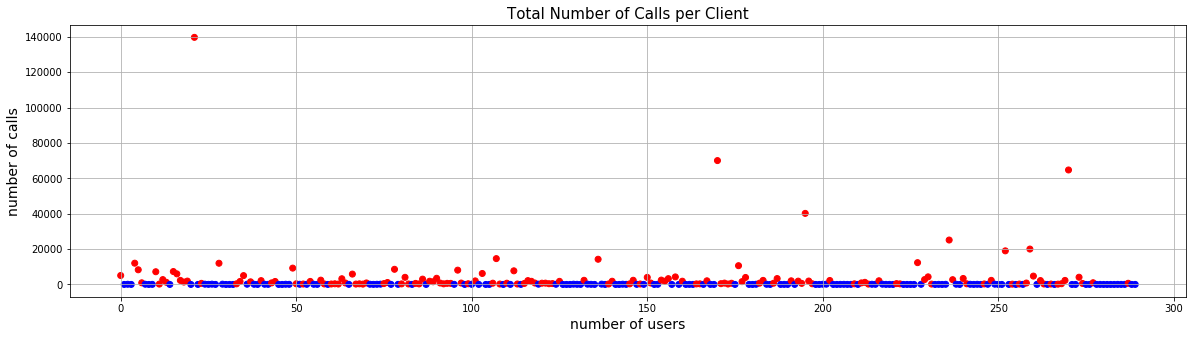

In [52]:
#Let's plot a scatter chart with the number of orders per user
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0,len(x)))
plt.title('Total Number of Calls per Client', fontdict={'size':15})
plt.xlabel("number of users", fontdict={'size':14})
plt.ylabel("number of calls", fontdict={'size':14})

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>167:
            cols.append('red')
        else:
            cols.append('blue')
    return cols
# Create the colors list using the function above
cols=pltcolor(x['calls_count'])
plt.scatter(x_values, x['calls_count'],c=cols) 
plt.grid()
plt.show()

In [53]:
#let's filter those who have less than 1320 total number of calls 
x_filtered = x.query('calls_count < 1320')
x_filtered.head(1)

,user_id,calls_count
1,166391,7


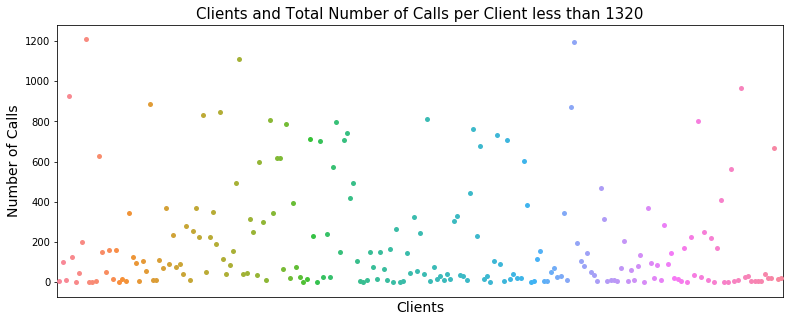

In [54]:
fig,ax=plt.subplots(figsize=(13,5))
sns.stripplot(x="user_id", y="calls_count", data=x_filtered) 
ax.set_title(
    'Clients and Total Number of Calls per Client less than 1320', fontdict={'size':15})
ax.set_ylabel(
    'Number of Calls', fontdict={'size':14})
ax.set_xlabel(
    'Clients', fontdict={'size':14})
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.show()

We found that while the average number of calls per client is 2420, 50% of clients have 167 calls, and only 25% of clients have more than 1320 calls.

In [55]:
#Let's calculate the 95th and 99th sample percentiles for the number of calls per client
print(np.percentile(x['calls_count'], [95, 99])) 

[ 8441.35 42870.4 ]


When checking the 95th and 99th sample percentiles for the number of calls, we found that not more than 5% of number of calls has value of more than 8441, and 1% of number of calls are more than 42870. Thus, it would be reasonable to set 8441 calls per client as the lower limit and to filter anomalies on that basis if needed.

In [56]:
df.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_sec
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5
1,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1


In [57]:
#let's set an indicator for the long wait for incoming calls where wait_sec is more than 376 sec

def long_wait_inc(df):

    if ((df['wait_sec'] > 376) and (df['direction'] == "in")):
        return True
    else: 
        return False

df['long_wait_inc'] = df.apply(long_wait_inc, axis = 1)

In [58]:
df.long_wait_inc.value_counts()

False    40858
True       633
Name: long_wait_inc, dtype: int64

What is user's lifetime

In [59]:
# let's find first activity month for every user
df['activity_month'] = df['date'].astype('datetime64[M]')
df['first_activity_month'] = df['date_start'].astype('datetime64[M]')

In [60]:
# let's find user's lifetime
df['lifetime_N_mnth'] = df['activity_month'] - df['first_activity_month']
df['lifetime_N_mnth'] = df['lifetime_N_mnth'] / np.timedelta64(1,'M')
df['lifetime_N_mnth'] = df['lifetime_N_mnth'].astype(int)
#df.lifetime_N_mnth.sort_values(ascending=False)

While checking lifetime, we can see that max lifetime duration is 4 months.

Let's check number of **missed incoming calls** per operator

In [97]:
df.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_sec,long_wait_inc,activity_month,first_activity_month,lifetime_N_mnth
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5,False,2019-08-01,2019-08-01,0
1,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1,False,2019-08-01,2019-08-01,0


In [121]:
#let's check total number of missed calls for each operator 
mo = df.query('is_missed_call == True and direction == "in"').groupby('operator_id').agg({'calls_count':'sum'}).reset_index()
print('{:.0%} of operators have missed incoming calls.' .format(mo.operator_id.nunique()/df.operator_id.nunique()))

22% of operators have missed incoming calls.


In [122]:
mo.describe()

,calls_count
count,239.000000
mean,3.870293
std,5.944060
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,52.000000


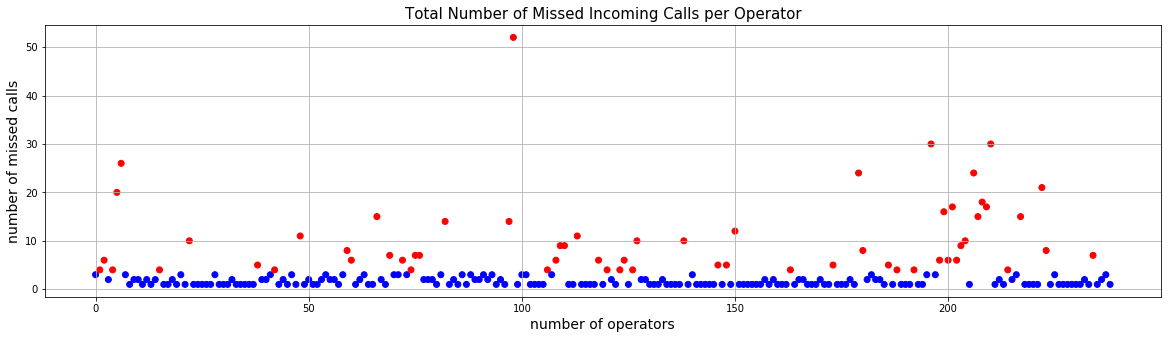

In [124]:
#Let's plot a scatter chart 
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0,len(mo)))
plt.title('Total Number of Missed Incoming Calls per Operator', fontdict={'size':15})
plt.xlabel("number of operators", fontdict={'size':14})
plt.ylabel("number of missed calls", fontdict={'size':14})

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>3:
            cols.append('red')
        else:
            cols.append('blue')
    return cols
# Create the colors list using the function above
cols=pltcolor(mo['calls_count'])
plt.scatter(x_values, mo['calls_count'],c=cols) 
plt.grid()
plt.show()

In [125]:
#Let's calculate the 95th and 99th sample percentiles 
#for the number of missed calls per operator
print(np.percentile(mo['calls_count'], [95, 99])) 

[15.1  28.48]


20% of operators have missed incoming calls. We found that while the average number of missed incoming calls per operator is 3.8, 50% of such operators have missed 2 incoming calls, and 75% of such operators have missed more than 4 calls. When checking the 95th and 99th sample percentiles, we found that not more than 5% of number of missed incoming calls has value of more than 15, and 1% of number of calls are more than 28. Thus, it would be reasonable to set 15 calls per operator as the lower limit for missed incoming calls.

### 2.3 Conclusion <a class="anchor" id="analysis-conc"></a>


In the present step we prepared the data for analysis: checked missing values - 15% of data on operator was missing (+55 entries on "internal" column), as operator_id is mandatory for our research, we had to drop these entries. Regarding data types, we corrected the date and time in df1, df2 tables. There were about 5k duplicated entries in the df1 table that we droped. Thus, we continue our cleaned data analysis with untouched df2 table and 41,491 out of initial 53,902 in df1 table (77%).

In addition, we cleaned our data by making sure that those calls that were missed have 0 as call duration (we replaced value with 0 for those where it was not the case and generated a table with user_id and call duration).

Thus, our data covers:
- Period of time from 2019-08-01 to 2019-11-27 with continous growth of entries towards the end of the period;
- 41,491 events;
- 290 unique users;
- 1092 operators.

While checking feature values we see that there are much more outgoing calls than incoming calls (leader is tariff A), that most clients call externally (out of their network) with the euqal distribution between tariff A and B vs much smaller part in tariff C (while tariff C is a leader in internal network calls), that the major operator in use for tariff C is 901884. 

Then, while checking features further, we saw that the average number of calls is 17, the average call duration is 1010 and the average total call duration is 1323. So, we decided to dig and dive into the call duration feature. We saw that the median, 50% of users, made 104 sec call duration and 75% of users mad 772 sec call duration. In total 12% of calls were longer than 2000 sec.

While checking calls that were not missed, we saw that maximum call count was in paln A, min - in plan B; that call duration in plan A is generally longer, while in plan B most calls are around 250 sec, same with the total duration of calls.

When checking the 95th and 99th sample percentiles for the waiting period, we found that not more than 5% of calls has value of more than 376, and 1% of incoming calls has waiting time of more than 928. Thus, it would be reasonable to set 376 sec per incoming calls as the lower limit and to filter anomalies on that basis.

When we checked correlation matrix we found that there is a strong correlation (98%) between total call duration and call duration,  number of calls and waiting period (87%), number of calls and total call duration (72%) and between total call duration and waiting period (69%). 

We can see that top 3 operators in terms of the missed calls:

- operator 885890 - 23,807 calls
- operator 885876 - 23,330 calls
- operator 929428 - 19,118 calls

We can see the same top 3 operators in terms of the biggest number of long wait incoming calls are: 
- operator 913938	- 4314 calls
- operator 921318	- 2170 calls
- operator 913942	- 1960 calls

We found that while the average number of calls per client is 2420, 50% of clients have 167 calls, and only 25% of clients have more than 1320 calls.

20% of operators have missed incoming calls. We found that while the average number of missed incoming calls per operator is 3.8, 50% of such operators have missed 2 incoming calls, and 75% of such operators have missed more than 4 calls. When checking the 95th and 99th sample percentiles, we found that not more than 5% of number of missed incoming calls has value of more than 15, and 1% of number of calls are more than 28. Thus, it would be reasonable to set 15 calls per operator as the lower limit for missed incoming calls.

## Step 3. Testing the hypothesis  <a class="anchor" id="checking"></a>

"The average number of missed calls changes based on tariff plan.”

"The average waiting period for incoming calls changes based on tariff plan.”

Setting the significance level (alpha) value.

In [61]:
#let's check if there are users in both groups A and B and filter them out
user_group = df.groupby('user_id').agg({'tariff_plan':'nunique'}).reset_index()
user_group = user_group.query('tariff_plan > 1')
user_group
#no users subscribed to the several tariff plans

,user_id,tariff_plan


In [62]:
#let's see how many users and orders we have in our sets
print('A group unique users:', df.query('tariff_plan == "A"')['user_id'].nunique())
print('B group unique users:', df.query('tariff_plan == "B"')['user_id'].nunique())
print('C group unique users:', df.query('tariff_plan == "C"')['user_id'].nunique())
print()
print('A group sample size:', df.query('tariff_plan == "A"')['user_id'].count())
print('B group sample size:', df.query('tariff_plan == "B"')['user_id'].count())
print('C group sample size:', df.query('tariff_plan == "C"')['user_id'].count())

A group unique users: 32
B group unique users: 101
C group unique users: 157

A group sample size: 12213
B group sample size: 14467
C group sample size: 14811


**number of missed calls**

Below we'll test the following H0 and H1 hypothesis :

- H0: The average number of missed calls of the group B equals to the group A
- H1: The average number of missed calls of the group B IS NOT equal to the group A


- H0: The average number of missed calls of the group B equals to the group C
- H1: The average number of missed calls of the group B IS NOT equal to the group C


- H0: The average number of missed calls of the group C equals to the group A
- H1: The average number of missed calls of the group C IS NOT equal to the group A

aplha = 0.05

Let's find the statistical significance of the difference in number of missed calls between the groups 


In [63]:
#let's create the variables to store the column calls_number based on tariff and missed calls indicator (True)

missedCallByUsersA = df.query('tariff_plan =="A" and is_missed_call == True').groupby('user_id').agg({'calls_count' :'sum'})['calls_count']
#missedCallByUsersA

missedCallByUsersB = df.query('tariff_plan =="B" and is_missed_call == True').groupby('user_id').agg({'calls_count' :'sum'})['calls_count']
#missedCallByUsersB

missedCallByUsersC = df.query('tariff_plan =="C" and is_missed_call == True').groupby('user_id').agg({'calls_count' :'sum'})['calls_count']
#missedCallByUsersC.head(1)

Let's use ttest method to determine if the means of three sets of data are significantly different from each other 
note: we calculate the t-test on independent samples, thus using ttest_ind and not ttest_rel.

In [64]:
print('The average number of missed calls is the same regardless of tariff plan C or B:')

#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_bc = st.ttest_ind(
    missedCallByUsersC, 
    missedCallByUsersB)

print('p-value calls:', results_bc.pvalue)
# compare the p-value to the statistical significance):
if (results_bc.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
print()

print('The average number of missed calls is the same regardless of tariff plan A or B:')

#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_ab = st.ttest_ind(
    missedCallByUsersA, 
    missedCallByUsersB)

print('p-value calls:', results_ab.pvalue)
# compare the p-value to the statistical significance):
if (results_ab.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
print()

print('The average number of missed calls is the same regardless of tariff plan C or A:')

#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_ac = st.ttest_ind(
    missedCallByUsersC, 
    missedCallByUsersA)

print('p-value calls:', results_ac.pvalue)
# compare the p-value to the statistical significance):
if (results_ac.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
print()


The average number of missed calls is the same regardless of tariff plan C or B:
p-value calls: 0.5844511064151372
We can't reject the null hypothesis

The average number of missed calls is the same regardless of tariff plan A or B:
p-value calls: 0.0004297854456438323
We reject the null hypothesis

The average number of missed calls is the same regardless of tariff plan C or A:
p-value calls: 0.0004224933665385948
We reject the null hypothesis



**waiting period**

Below we'll test the following H0 and H1 hypothesis :

- H0: The average waiting period of the group B equals to the group A
- H1: The average waiting period of the group B IS NOT equal to the group A
    

- H0: The average waiting period of the group B equals to the group C
- H1: The average waiting period of the group B IS NOT equal to the group C

- H0: The average waiting period of the group C equals to the group A
- H1: The average waiting period of the group C IS NOT equal to the group A
  
aplha = 0.05

Let's find the statistical significance of the difference in average waiting period between the groups

In [65]:
#let's create the variables to store the column wait_sec based on tariff

waitPeriodByUsersA = df.query('tariff_plan =="A" and direction == "in"').groupby('user_id').agg({'wait_sec' :'sum'})['wait_sec']
#waitPeriodByUsersA

waitPeriodByUsersB = df.query('tariff_plan =="B" and direction == "in"').groupby('user_id').agg({'wait_sec' :'sum'})['wait_sec']
#waitPeriodByUsersB

waitPeriodByUsersC = df.query('tariff_plan =="C" and direction == "in"').groupby('user_id').agg({'wait_sec' :'sum'})['wait_sec']
#waitPeriodByUsersC.head(1)

Let's use ttest method to determine if the means of three sets of data are significantly different from each other note: we calculate the t-test on independent samples, thus using ttest_ind and not ttest_rel

In [66]:
print('The average waiting period is the same regardless of tariff plan C or B:')

#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_bc = st.ttest_ind(
    waitPeriodByUsersB, 
    waitPeriodByUsersC)

print('p-value calls:', results_bc.pvalue)
# compare the p-value to the statistical significance):
if (results_bc.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
print()

print('The average waiting period is the same regardless of tariff plan A or B:')

#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_ab = st.ttest_ind(
    waitPeriodByUsersA, 
    waitPeriodByUsersB)

print('p-value calls:', results_ab.pvalue)
# compare the p-value to the statistical significance):
if (results_ab.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
print()

print('The average waiting period is the same regardless of tariff plan C or A:')

#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_ac = st.ttest_ind(
    waitPeriodByUsersA, 
    waitPeriodByUsersC)

print('p-value calls:', results_ac.pvalue)
# compare the p-value to the statistical significance):
if (results_ac.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
print()


The average waiting period is the same regardless of tariff plan C or B:
p-value calls: 0.10184624476677522
We can't reject the null hypothesis

The average waiting period is the same regardless of tariff plan A or B:
p-value calls: 0.15596134487729496
We can't reject the null hypothesis

The average waiting period is the same regardless of tariff plan C or A:
p-value calls: 0.00011586683251971727
We reject the null hypothesis



### 3.1 Conclusion <a class="anchor" id="checking-conc"></a>


Based on our ttests, we found that in most cases (A & B, A & C) we reject the null hypothesis except one: for plans B & C ; the same picture for both scenarios - number of missed calls and waiting period for incoming calls.

Testing null hypothesis: we used ttest_ind method (and not ttest_rel). If we reject the null hypothesis - means both samples are vrey different to each other taking into account signifficance limit (5% in our case). If we fail to reject the null - means there is no difference between samles. 

We performed following tests: 

- Whether the average number of missed calls are the same regardless of the users' tariff. As a result, we found that average number of missed calls is very different between tariffs A & B and A & C, and is similar for plans B & C, taking into account the limit of significance of 5%.

- Whether the average waiting period for incoming calls is the same regardless of the users' tariff. As a result, we found that average waiting period for incoming calls is very different between tariffs A & C, and is similar for plans A & B and B & C, taking into account the limit of significance of 5%.

## Step 4. Creating operators’ clusters and coming up with conclusions  <a class="anchor" id="clusters"></a>

* Creating operator’s clusters
    * Standardizing the data.
    * Using the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. 
    * Training the clustering model with the K-means algorithm and predict customer clusters (number of clusters will be based on the graph from the previous step)
    * Looking at the mean feature values for clusters
    * Calculating the list effective cluster 
* Draw conclusions on the least effective operators


In [67]:
#let's create a table of features per operator
df_op1=df.groupby(['operator_id','tariff_plan','direction','internal','is_missed_call','long_wait_inc']).agg({'call_duration':'sum','calls_count':'sum' ,'wait_sec':'sum'}).reset_index()
df_op1.head(2)

,operator_id,tariff_plan,direction,internal,is_missed_call,long_wait_inc,call_duration,calls_count,wait_sec
0,879896,B,in,False,False,False,5616,58,574
1,879896,B,out,False,False,False,56972,596,5783


If an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.
Let's define this indicator.

In [68]:
#let's find number of outgoing calls per operator
x=df_op1.query('direction=="out"').groupby('operator_id').agg({'calls_count':'sum'}).sort_values(by='calls_count',ascending=False).reset_index()
x.describe()

,calls_count
count,882.000000
mean,689.731293
std,3122.953946
min,1.000000
25%,11.000000
50%,90.000000
75%,597.250000
max,58977.000000


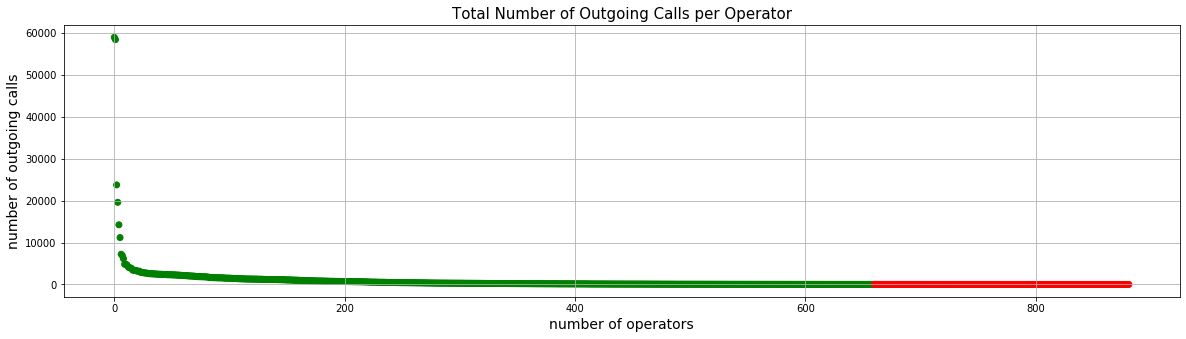

In [69]:
#Let's plot a scatter chart with the number of outgoing calls per operator
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0,len(x)))
plt.title('Total Number of Outgoing Calls per Operator', fontdict={'size':15})
plt.xlabel("number of operators", fontdict={'size':14})
plt.ylabel("number of outgoing calls", fontdict={'size':14})

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>11:
            cols.append('green')
        else:
            cols.append('red')
    return cols
# Create the colors list using the function above
cols=pltcolor(x['calls_count'])
plt.scatter(x_values, x['calls_count'],c=cols) 
plt.grid()
plt.show()

We can see that in average there are 690 outgoing calls per operator, that 25% have 11 calls, 50% of operators have 90 outgoing calls and 75% of operators made 597 outgoing calls.

Let's take a look on those who have less than 90 outgoing calls

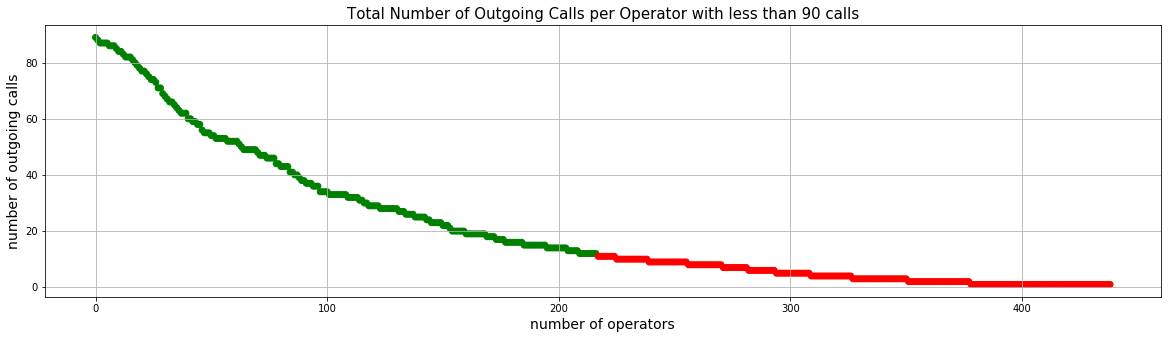

In [70]:
#Let's plot a scatter chart with the number of outgoing calls per operator
x_filtered=x.query('calls_count < 90')
plt.figure(figsize = (20,5))
x_values = pd.Series(range(0,len(x_filtered)))
plt.title('Total Number of Outgoing Calls per Operator with less than 90 calls', fontdict={'size':15})
plt.xlabel("number of operators", fontdict={'size':14})
plt.ylabel("number of outgoing calls", fontdict={'size':14})

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>11:
            cols.append('green')
        else:
            cols.append('red')
    return cols
# Create the colors list using the function above
cols=pltcolor(x_filtered['calls_count'])
plt.scatter(x_values, x_filtered['calls_count'],c=cols) 
plt.grid()
plt.show()

We can see that 11 outgoing calls per operator could be a good indicator of inefficiency.

In [71]:
#Let's set the indicator for operators who have less than 11 outgoing calls (df_op1 table)

inefficient_out=x[x.calls_count < 11]['operator_id'].unique()
len(inefficient_out)

df_op1['inefficient_out'] = df_op1['operator_id'].apply(lambda x: True if x in inefficient_out else False)
df_op1.inefficient_out.value_counts()


False    2987
True      521
Name: inefficient_out, dtype: int64

When checking inefficient operators in terms of outgoing calls we set 11 as limit number of outgoing calls to set it to True and identified 521 operators out of more than 3k operators.

In [73]:
#let's create a table of features per operator
df_op2=df_op1.groupby(['operator_id','tariff_plan','is_missed_call','long_wait_inc','inefficient_out']).agg({'call_duration':'sum','calls_count':'sum','wait_sec':'sum'}).reset_index()

df_op2.head(1)

,operator_id,tariff_plan,is_missed_call,long_wait_inc,inefficient_out,call_duration,calls_count,wait_sec
0,879896,B,False,False,False,63862,679,6538


Let's check feature distribution based on operator

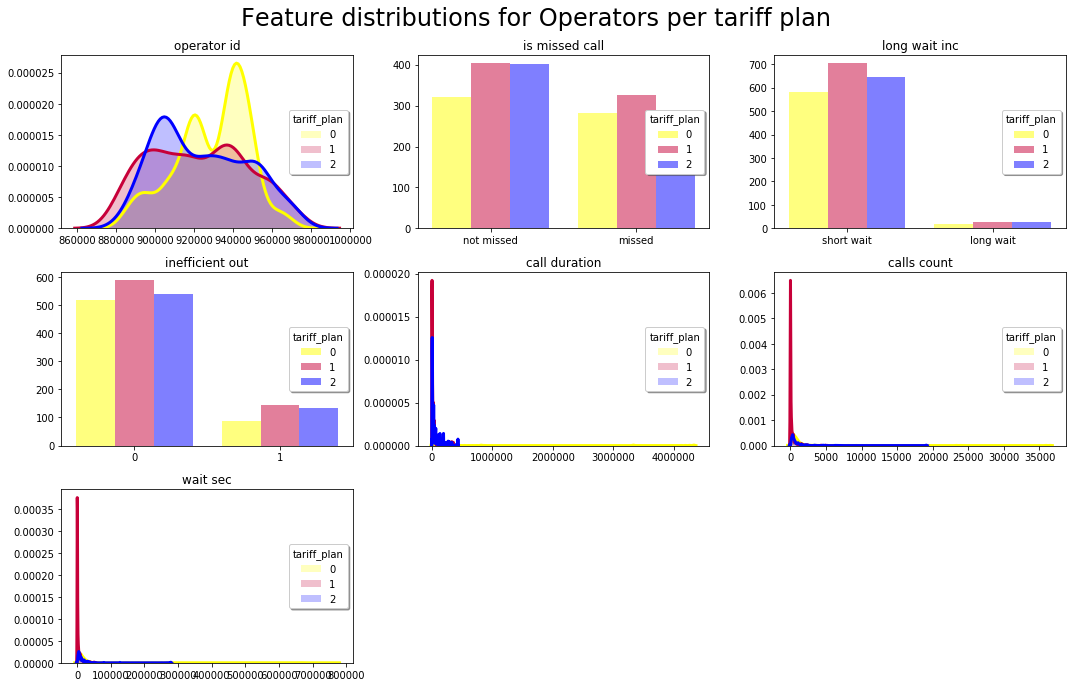

In [95]:
#let's define plot distribution of features for each claster
colors = ['yellow','#C70039','blue']

def plot_dist(df, feature):
    plt.figure(figsize=(15,15))
    the_grid = GridSpec(5, 3)
    # place in grid for plot
    for i, column in enumerate(df.drop(feature, axis = 1).columns):
        plt.subplot(the_grid[i//3, i%3], title=column.replace('_',' '))
        values = len(df[column].unique())
        features = sorted(df[feature].unique())
    # continuous vs discrete
        if values > 12:    
            for i,x in enumerate(features):
                sns.distplot(df[df[feature] == x][column], hist = False, 
                             kde_kws = {'shade': True, 'linewidth': 3}, color=colors[i])
        else:
            sns.countplot(column, hue=feature, data=df, palette=colors, alpha=.5, saturation=1)
            plt.gca().get_legend().remove()
     # xticks
            if values == 2:
                if column == 'direction':
                    plt.xticks(np.arange(values),('out','in'))
                if column == 'is_missed_call':
                    plt.xticks(np.arange(values),('not missed','missed'))
                if column == 'internal':
                    plt.xticks(np.arange(values),('external','internal'))
                if column == 'long_wait_inc':
                    plt.xticks(np.arange(values),('short wait','long wait'))
     # legend             
        legend = features
        plt.legend(legend, shadow=True, fancybox=True, title=feature, loc='center right')
        plt.xlabel('')
        plt.ylabel('')
    plt.tight_layout()
    plt.suptitle('Feature distributions for Operators per tariff plan', fontsize=24, y=1.02)
    plt.show()
plot_dist(df_op2,'tariff_plan')

We can see that for those operators who have long wait period for incoming calls most clients have plan B. That inefficient operators in terms of outgoing calls (less then 11) have clients in plan A. That most missed calls have operators with clients under plan A.

Let's convert all string values to numbers

In [75]:
#plan A - 0, B - 1, C-2
df_op2['tariff_plan'] = df_op2['tariff_plan'].replace({'A': 0, 'B': 1, 'C':2})
df_op2.tariff_plan.value_counts()

#call is missed false - 0, true - 1
df_op2['is_missed_call'] = df_op2['is_missed_call'].replace({False: 0, True : 1})
df_op2.is_missed_call.value_counts()

#long wait: false - 0, true - 1
df_op2['long_wait_inc'] = df_op2['long_wait_inc'].replace({False: 0, True : 1})
df_op2.long_wait_inc.value_counts()

#long wait: false - 0, true - 1
df_op2['inefficient_out'] = df_op2['inefficient_out'].replace({False: 0, True : 1})
df_op2.inefficient_out.value_counts()

df_op2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005 entries, 0 to 2004
Data columns (total 8 columns):
operator_id        2005 non-null object
tariff_plan        2005 non-null int64
is_missed_call     2005 non-null int64
long_wait_inc      2005 non-null int64
inefficient_out    2005 non-null int64
call_duration      2005 non-null int64
calls_count        2005 non-null int64
wait_sec           2005 non-null int64
dtypes: int64(7), object(1)
memory usage: 125.4+ KB


Now let's build our clusters

In [76]:
#Standardizing the data, setting aside the column with data on tariff_plan

df_op=df.groupby(['operator_id','is_missed_call','long_wait_inc']).agg({'call_duration':'sum','calls_count':'sum','wait_sec':'sum'}).reset_index()
#set the indicator for operators who have less than 11 outgoing calls (inefficient_out list)
df_op['inefficient_out'] = df_op['operator_id'].apply(lambda x: True if x in inefficient_out else False)

scaler = StandardScaler()
x_sc = scaler.fit_transform(df_op)

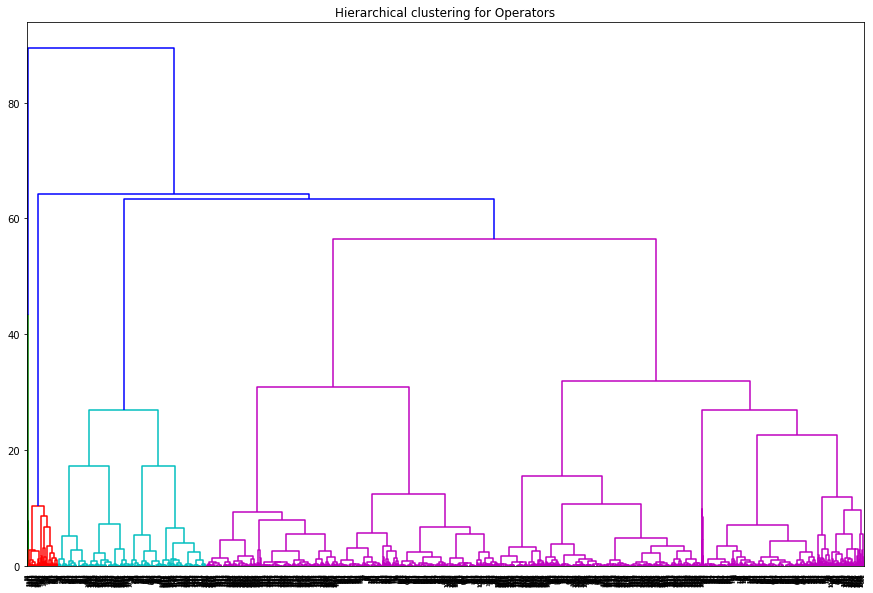

In [77]:
#Using the linkage() function to build a matrix of distances and ploting a dendrogram
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top',show_leaf_counts=True)
plt.title('Hierarchical clustering for Operators')
plt.show() 

Using the resulting graph we can estimate the number of clusters that can singled out - 3.

Now let's train the clustering model with the K-means algorithm and predict customer clusters (the number of clusters will be 3).

In [78]:
#let's define the k_means model with 3 clusters
km = KMeans(n_clusters = 3, random_state=0)

In [79]:
# predict the clusters for observations (the algorithm assigns them a number from 0 to 2)
labels = km.fit_predict(x_sc)

In [80]:
# store cluster labels in the field of our dataset
df_op['cluster'] = labels
#df_op.cluster.value_counts()
#df_op.head(20)

Now let's look at the mean feature values for clusters and plot distributions of features for the clusters, then calculating the missed call and long wait rate for each cluster.

In [81]:
#let's see on the mean feature values for clusters
round(df_op.groupby('cluster').mean(),1)

,is_missed_call,long_wait_inc,call_duration,calls_count,wait_sec,inefficient_out
cluster,,,,,,
0,0.0,0.1,30396.2,317.4,4747.2,0.2
1,1.0,0.0,27.0,257.3,5483.1,0.2
2,0.5,0.0,1923791.8,29880.8,702764.5,0.0


While checking mean feature values in 3 clusters we see that in the 2nd cluster operators have 100% of missed calls, and the inefficient indicator in terms of outgoing calls on 20% (highest mean).

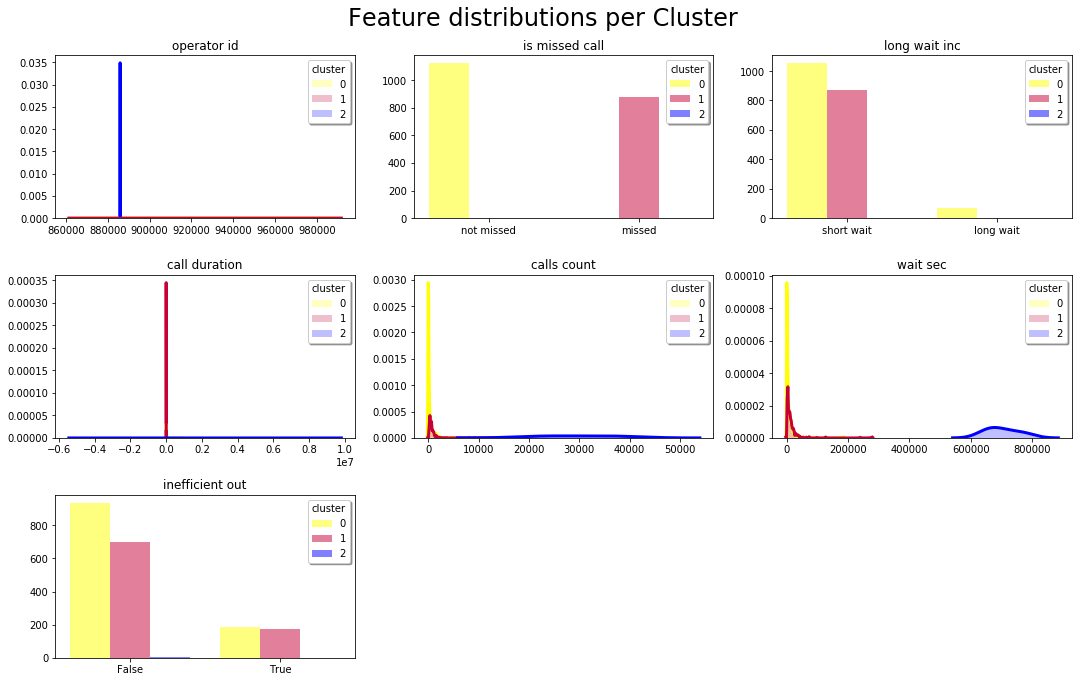

In [96]:
#let's define plot distribution of features for each claster
colors = ['yellow','#C70039','blue']

def plot_dist(df, feature):
    plt.figure(figsize=(15,15))
    the_grid = GridSpec(5, 3)
    # place in grid for plot
    for i, column in enumerate(df.drop(feature, axis = 1).columns):
        plt.subplot(the_grid[i//3, i%3], title=column.replace('_',' '))
        values = len(df[column].unique())
        features = sorted(df[feature].unique())
    # continuous vs discrete
        if values > 12:    
            for i,x in enumerate(features):
                sns.distplot(df[df[feature] == x][column], hist = False, 
                             kde_kws = {'shade': True, 'linewidth': 3}, color=colors[i])
        else:
            sns.countplot(column, hue=feature, data=df, palette=colors, alpha=.5, saturation=1)
            plt.gca().get_legend().remove()
     # xticks
            if values == 2:
                if column == 'direction':
                    plt.xticks(np.arange(values),('out','in'))
                if column == 'is_missed_call':
                    plt.xticks(np.arange(values),('not missed','missed'))
                if column == 'internal':
                    plt.xticks(np.arange(values),('external','internal'))
                if column == 'long_wait_inc':
                    plt.xticks(np.arange(values),('short wait','long wait'))
     # legend             
        if feature == 'cluster':
            legend = ['1','2','3','4']
        if feature == 'tariff_plan':
            legend = ['A','B','C']
        else:
            legend = features
            plt.legend(legend, shadow=True, fancybox=True, title=feature, loc='upper right')
        plt.xlabel('')
        plt.ylabel('')
    plt.tight_layout()
    plt.suptitle('Feature distributions per Cluster', fontsize=24, y=1.02)
    plt.show()
plot_dist(df_op,'cluster')

In [83]:
cluster1_op=df_op.query('cluster == 0')['operator_id'].unique()
print('number of operators cluster 1:', len(cluster1_op))
cluster2_op=df_op.query('cluster == 1')['operator_id'].unique()
print('number of operators cluster 2:', len(cluster2_op))
cluster3_op=df_op.query('cluster == 2')['operator_id'].unique()
print('number of operators cluster 3:', len(cluster3_op))
#df_op.groupby(['operator_id','cluster']).size().sort_values(ascending=False)

number of operators cluster 1: 1057
number of operators cluster 2: 874
number of operators cluster 3: 2


When checking feature distribution per cluster we can see that in the 1st cluster we have 1057 operators, that their long wait is higher than in other groups, and in the 2nd cluster we have 874 operators with the highest number of missed calls, both 1st and 2nd clusters operators have inefficient number of outgoing calls indicator present almost equally.

### 4.1 Conclusion <a class="anchor" id="results-conc"></a>

In the present step we worked with operators, identifiying clusters of those who might be considered as less efficient. We saw for those operators who have long wait period for incoming calls most clients have plan B. That inefficient operators in terms of outgoing calls (less then 11) have clients in plan A. That most missed calls have operators with clients under plan A.

Then, using dendrogram we estimated 3 clusters and based on this number trained the clustering model with the K-means algorithm and predicted operators clusters.

While checking mean feature values in 3 clusters we see that in the 2nd cluster operators have 100% of missed calls, and the inefficient indicator in terms of outgoing calls on 20% (highest mean). When checking feature distribution per cluster we can see that in the 1st cluster we have 1057 operators, that their long wait is higher than in other groups, and in the 2nd cluster we have 874 operators with the highest number of missed calls, both 1st and 2nd clusters operators have inefficient number of outgoing calls indicator present almost equally.

## Step 5. General conclusion  <a class="anchor" id="conclusion"></a>



In the present research we worked for the CallMeMaybe company that plans to develop a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have 

- **large number of missed incoming calls (internal and external)**
- **long waiting time for incoming calls**
- **small number of outgoing calls**

Our customer is Product Manager, Product Development Department. In the future, on the basis of the present analysis, an algorithm will be developed for embedding into the service as a separate functionality.

The datasets contain data on the use of the virtual telephony service. Its clients are organizations that need to distribute large numbers of incoming calls among various operators or make outgoing calls through their operators. Operators can also make internal calls to communicate with one another. These calls go through CallMeMaybe's network.

In the present research we were working with a 2 datasets that were saved in the following tables:
df1 - 1st dataset telecom_dataset_us.csv - its total length is 53901 rows, every row represents one client's activity log and its characteristics in columns:
* user_id — client account ID
* date — date the statistics were retrieved
* direction — call direction (out for outgoing, in for incoming)
* internal — whether the call was internal (between a client's operators)
* operator_id — operator identifier
* is_missed_call — whether the call was missed
* calls_count — number of calls user did in particular date to particular operator_id with particular direction and so on
* call_duration — call duration (excluding waiting time) - in seconds
* total_call_duration — call duration (including waiting time)

df2 - 2nd dataset telecom_clients_us.csv - its total length is 732 rows, every row represents one client's account and its characteristics in columns:

* user_id
* tariff_plan — client's current plan
* date_start — client's registration date

Then we prepared the data for analysis: checked missing values - 15% of data on operator was missing (+55 entries on "internal" column), as operator_id is mandatory for our research, we had to drop these entries. Regarding data types, we corrected the date and time in df1, df2 tables. There were about 5k duplicated entries in the df1 table that we dropped. Thus, we continue our cleaned data analysis with untouched df2 table and 41,491 out of initial 53,902 in df1 table (77%). In addition, we cleaned our data by making sure that those calls that were missed have 0 as call duration (we replaced value with 0 for those where it was not the case and generated a table with user_id and call duration).

Thus, our data covers:
* Period of time from 2019-08-01 to 2019-11-27 with continuous growth of entries towards the end of the period;
* 41,491 events;
* 290 unique users;
* 1902 operators.

While checking feature values we saw that there are much more outgoing calls than incoming calls (leader is tariff A), that most clients call externally (out of their network) with the equal distribution between tariff A and B vs much smaller part in tariff C (while tariff C is a leader in internal network calls), that the major operator in use for tariff C is 901884.

Then, while checking features further, we saw that the average number of calls is 17, the average call duration is 1010 and the average total call duration is 1323. So, we decided to dig and dive into the call duration feature. We saw that the median, 50% of users, made 104 sec call duration and 75% of users made 772 sec call duration. In total 12% of calls were longer than 2000 sec.

While checking calls that were not missed, we saw that maximum call count was in plan A, min - in plan B; that call duration in plan A is generally longer, while in plan B most calls are around 250 sec, same with the total duration of calls.

When checking the 95th and 99th sample percentiles for the waiting period, we found that not more than 5% of calls has value of more than 376, and 1% of incoming calls has waiting time of more than 928. Thus, it would be reasonable to set 376 sec per incoming calls as the lower limit and to filter anomalies on that basis.

When we checked correlation matrix we found that there is a strong correlation (98%) between total call duration and call duration, number of calls and waiting period (87%), number of calls and total call duration (72%) and between total call duration and waiting period (69%).

We can see that top 3 operators in terms of the missed calls:

* operator 885890 - 23,807 calls
* operator 885876 - 23,330 calls
* operator 929428 - 19,118 calls

We can see the same top 3 operators in terms of the biggest number of long wait incoming calls are:

* operator 913938 - 4314 calls
* operator 921318 - 2170 calls
* operator 913942 - 1960 calls

We found that while the average number of calls per client is 2420, 50% of clients have 167 calls, and only 25% of clients have more than 1320 calls.

20% of operators have missed incoming calls. We found that while the average number of missed incoming calls per operator is 3.8, 50% of such operators have missed 2 incoming calls, and 75% of such operators have missed more than 4 calls. When checking the 95th and 99th sample percentiles, we found that not more than 5% of number of missed incoming calls has value of more than 15, and 1% of number of calls are more than 28. Thus, it would be reasonable to set 15 calls per operator as the lower limit for missed incoming calls.

Based on our ttests, we found that in most cases (A & B, A & C) we reject the null hypothesis except one: for plans B & C ; the same picture for both scenarios - number of missed calls and waiting period for incoming calls.

Testing null hypothesis: we used ttest_ind method (and not ttest_rel). If we reject the null hypothesis - means both samples are vrey different to each other taking into account signifficance limit (5% in our case). If we fail to reject the null - means there is no difference between samles.

We performed following tests:

* Whether the average number of missed calls are the same regardless of the users' tariff. As a result, we found that average number of missed calls is very different between tariffs A & B and A & C, and is similar for plans B & C, taking into account the limit of significance of 5%. 
* Whether the average waiting period for incoming calls is the same regardless of the users' tariff. As a result, we found that average waiting period for incoming calls is very different between tariffs A & C, and is similar for plans A & B and B & C, taking into account the limit of significance of 5%.

Further, we worked with operators, identifying clusters of those who might be considered as less efficient. We saw that those operators who have long wait period for incoming calls most clients have plan B. That inefficient operators in terms of outgoing calls (less than 11) have clients in plan A. That most missed calls have operators with clients under plan A.

Then, using dendrogram we estimated 3 clusters and based on this number trained the clustering model with the K-means algorithm and predicted operators clusters.

While checking mean feature values in 3 clusters we saw that in the 2nd cluster operators have 100% of missed calls, and the inefficient indicator in terms of outgoing calls on 20% (highest mean). When checking feature distribution per cluster we can saw that in the 1st cluster we had 1057 operators and that their long wait is higher than in other groups, and in the 2nd cluster we had 874 operators, this group had the highest number of missed calls, both 1st and 2nd clusters operators have inefficient number of outgoing calls indicator present almost equally.

**We had more that 41k events of 290 unique users and 1.9k unique operators to find out the inefficient behaviour during Aug 1 - Nov 27 2019. 
We saw that there is no straight forward dependancy on the tariff plan for inefficient calls (missed/with long waiting time/small outgoing number of calls).
We trained our model to define clusters and finally have two groups of operators, first cluster can be “punished” for the big number of missed calls while the other one - for the long waiting period, both clusters have significant percent of operators that perform small number of outgoing calls.**


**Rules to determine less effective operators:**

- number of missed incoming calls (internal and external): **more than 15**
- waiting time for incoming calls: **more than 376 sec**
- small number of outgoing calls: **less than 11**

# Presentation

# Link
https://drive.google.com/file/d/1_9hDTR8mm3JQO_YkVWpUADJLGPtaj3mK/view?usp=sharing